In [55]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

plt.rcParams['font.family'] = 'SimHei' #设置字体
plt.rcParams['axes.unicode_minus']=False #坐标轴的负号正常显示

In [57]:
keypoints_2d = []
for i in range(924):
    num_str = str(i).zfill(3)
    path = "./key_points/Motion_000000000%s_keypoints.json"%num_str
    with open(path, 'r') as fp:
        keypoints_2d.append(json.load(fp)['people'][0]['pose_keypoints_2d'])
        
df = pd.DataFrame(keypoints_2d)
# df.to_excel("keypoints.xlsx")

In [58]:
bodyparts = ["鼻子","脖子","右肩","右肘","右腕","左肩","左肘","左腕","右髋","右膝","右踝","左髋","左膝","左踝","右眼","左眼","右耳","左耳"]
column_easy_read = []
for bodypart in enumerate(bodyparts):
    column_easy_read.append(str(bodypart[0])+bodypart[1]+'x')
    column_easy_read.append(str(bodypart[0])+bodypart[1]+'y')
    column_easy_read.append(str(bodypart[0])+bodypart[1]+'conf')
    
df_column_changed = df.copy()
df_column_changed.columns = column_easy_read
df_column_changed

,0鼻子x,0鼻子y,0鼻子conf,1脖子x,1脖子y,1脖子conf,2右肩x,2右肩y,2右肩conf,3右肘x,...,14右眼conf,15左眼x,15左眼y,15左眼conf,16右耳x,16右耳y,16右耳conf,17左耳x,17左耳y,17左耳conf
0,736.243,559.675,0.650311,830.475,515.602,0.626633,836.309,600.905,0.620409,912.859,...,0.745269,715.530,539.065,0.703324,736.274,583.396,0.082676,715.718,486.126,1.025990
1,733.389,556.792,0.595327,827.553,512.621,0.627159,836.289,597.999,0.622575,912.937,...,0.738161,715.528,536.187,0.680843,736.184,583.247,0.081972,715.726,483.256,1.009070
2,736.235,553.823,0.575404,827.588,509.699,0.646545,833.461,597.945,0.623604,912.921,...,0.746082,715.513,530.359,0.690788,736.364,577.481,0.093948,715.664,480.377,0.980916
3,736.290,550.914,0.625083,830.523,506.793,0.636211,833.518,597.979,0.610875,915.866,...,0.799011,715.566,530.218,0.724259,736.248,577.461,0.106643,715.727,480.187,0.997391
4,733.396,547.957,0.612491,827.561,503.877,0.641337,833.523,589.149,0.565578,912.916,...,0.795002,712.804,527.314,0.707544,727.511,577.271,0.093739,715.656,477.347,1.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,698.046,400.791,0.443984,806.982,403.669,0.684251,812.881,480.325,0.637592,889.424,...,0.789635,683.350,383.108,0.559931,701.005,456.791,0.297579,692.245,362.443,0.752677
920,695.089,391.957,0.448315,806.954,403.657,0.686810,812.859,480.303,0.634160,892.257,...,0.702814,680.409,380.169,0.509435,701.050,456.781,0.300898,692.210,362.532,0.764218
921,695.023,392.048,0.437441,806.936,403.665,0.674410,812.898,480.331,0.619241,892.305,...,0.704544,677.530,383.130,0.500821,701.085,456.812,0.278024,692.182,362.562,0.811618
922,695.153,397.869,0.422071,806.932,403.691,0.669535,812.879,480.314,0.633211,892.325,...,0.742179,680.409,386.074,0.510983,706.831,459.559,0.266360,692.187,362.624,0.832441


In [59]:
# 对置信度水平排序，位于后5%的点进行三次样条插值（前后各10个点不进行样条插值，因为可能边界会异常）
def dot_fill_low_conf(df, columns_id):
    df_cp = df.copy()

    low_conf = (df.iloc[:,columns_id[2]].sort_values(ignore_index=True))[int(924*0.05)]

    num_for_subsititute_id = np.where(df.iloc[:,columns_id[2]] <= low_conf)[0]
    normal_id = df.index.drop(num_for_subsititute_id)
    
    CS_x = CubicSpline(normal_id, df.iloc[normal_id,columns_id[0]])
    df.loc[num_for_subsititute_id, columns_id[0]] = CS_x(num_for_subsititute_id)

    CS_y = CubicSpline(normal_id, df.iloc[normal_id,columns_id[1]])
    df.iloc[num_for_subsititute_id, columns_id[1]] = CS_y(num_for_subsititute_id)
    
    CS_conf = CubicSpline(normal_id, df.iloc[normal_id, columns_id[2]])
    df.iloc[num_for_subsititute_id, columns_id[2]] = CS_conf(num_for_subsititute_id)

    df.iloc[:10,columns_id] = df_cp.iloc[:10,columns_id]
    df.iloc[-10:,columns_id] = df_cp.iloc[-10:,columns_id]

    return df

def fill_low_conf(df):
    for i in range(18):
        # df.iloc[:,[3*i,3*i+1,3*i+2]] = dot_fill_low_conf(df.iloc[:,[3*i,3*i+1,3*i+2]])
        dot_fill_low_conf(df, [3*i,3*i+1,3*i+2])

df_fill_low_conf = df.copy()
fill_low_conf(df_fill_low_conf)
# df_fill_low_conf.to_excel("keypoints(对低置信度插值).xlsx")
df_fill_low_conf

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,736.243,559.675,0.650311,830.475,515.602,0.626633,836.309,600.905,0.620409,912.859,...,0.745269,715.530,539.065,0.703324,736.274,583.396,0.082676,715.718,486.126,1.025990
1,733.389,556.792,0.595327,827.553,512.621,0.627159,836.289,597.999,0.622575,912.937,...,0.738161,715.528,536.187,0.680843,736.184,583.247,0.081972,715.726,483.256,1.009070
2,736.235,553.823,0.575404,827.588,509.699,0.646545,833.461,597.945,0.623604,912.921,...,0.746082,715.513,530.359,0.690788,736.364,577.481,0.093948,715.664,480.377,0.980916
3,736.290,550.914,0.625083,830.523,506.793,0.636211,833.518,597.979,0.610875,915.866,...,0.799011,715.566,530.218,0.724259,736.248,577.461,0.106643,715.727,480.187,0.997391
4,733.396,547.957,0.612491,827.561,503.877,0.641337,833.523,589.149,0.565578,912.916,...,0.795002,712.804,527.314,0.707544,727.511,577.271,0.093739,715.656,477.347,1.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,698.046,400.791,0.443984,806.982,403.669,0.684251,812.881,480.325,0.637592,889.424,...,0.789635,683.350,383.108,0.559931,701.005,456.791,0.297579,692.245,362.443,0.752677
920,695.089,391.957,0.448315,806.954,403.657,0.686810,812.859,480.303,0.634160,892.257,...,0.702814,680.409,380.169,0.509435,701.050,456.781,0.300898,692.210,362.532,0.764218
921,695.023,392.048,0.437441,806.936,403.665,0.674410,812.898,480.331,0.619241,892.305,...,0.704544,677.530,383.130,0.500821,701.085,456.812,0.278024,692.182,362.562,0.811618
922,695.153,397.869,0.422071,806.932,403.691,0.669535,812.879,480.314,0.633211,892.325,...,0.742179,680.409,386.074,0.510983,706.831,459.559,0.266360,692.187,362.624,0.832441


In [60]:
# 计算关节之间的2d距离
def cal_joints_lenths_2d(df, joints_id):
    joint0xy = df.loc[:,[joints_id[0]*3, joints_id[0]*3+1]]
    joint1xy = df.loc[:,[joints_id[1]*3, joints_id[1]*3+1]]
    lengths_2d = ((joint0xy.values - joint1xy.values)**2).sum(axis=1)**(1/2)
    return lengths_2d

In [61]:
# 对630到660帧之间双臂错误位置进行线性插值
def dot_fill_error(df, columns_id):
    df_cp = df.copy()

    num_for_subsititute_id = df.index[630:660]
    normal_id = df.index.drop(num_for_subsititute_id)

    df.iloc[num_for_subsititute_id, columns_id[0]] = np.interp(num_for_subsititute_id, normal_id, df.iloc[normal_id, columns_id[0]])
    df.iloc[num_for_subsititute_id, columns_id[1]] = np.interp(num_for_subsititute_id, normal_id, df.iloc[normal_id, columns_id[1]])
    df.iloc[num_for_subsititute_id, columns_id[2]] = np.interp(num_for_subsititute_id, normal_id, df.iloc[normal_id, columns_id[2]])


    return df

def fill_error(df):
    for i in range(2,8):
        dot_fill_error(df, [3*i,3*i+1,3*i+2])

df_fill_error = df_fill_low_conf.copy()
fill_error(df_fill_error)
df_fill_error

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,736.243,559.675,0.650311,830.475,515.602,0.626633,836.309,600.905,0.620409,912.859,...,0.745269,715.530,539.065,0.703324,736.274,583.396,0.082676,715.718,486.126,1.025990
1,733.389,556.792,0.595327,827.553,512.621,0.627159,836.289,597.999,0.622575,912.937,...,0.738161,715.528,536.187,0.680843,736.184,583.247,0.081972,715.726,483.256,1.009070
2,736.235,553.823,0.575404,827.588,509.699,0.646545,833.461,597.945,0.623604,912.921,...,0.746082,715.513,530.359,0.690788,736.364,577.481,0.093948,715.664,480.377,0.980916
3,736.290,550.914,0.625083,830.523,506.793,0.636211,833.518,597.979,0.610875,915.866,...,0.799011,715.566,530.218,0.724259,736.248,577.461,0.106643,715.727,480.187,0.997391
4,733.396,547.957,0.612491,827.561,503.877,0.641337,833.523,589.149,0.565578,912.916,...,0.795002,712.804,527.314,0.707544,727.511,577.271,0.093739,715.656,477.347,1.001560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,698.046,400.791,0.443984,806.982,403.669,0.684251,812.881,480.325,0.637592,889.424,...,0.789635,683.350,383.108,0.559931,701.005,456.791,0.297579,692.245,362.443,0.752677
920,695.089,391.957,0.448315,806.954,403.657,0.686810,812.859,480.303,0.634160,892.257,...,0.702814,680.409,380.169,0.509435,701.050,456.781,0.300898,692.210,362.532,0.764218
921,695.023,392.048,0.437441,806.936,403.665,0.674410,812.898,480.331,0.619241,892.305,...,0.704544,677.530,383.130,0.500821,701.085,456.812,0.278024,692.182,362.562,0.811618
922,695.153,397.869,0.422071,806.932,403.691,0.669535,812.879,480.314,0.633211,892.325,...,0.742179,680.409,386.074,0.510983,706.831,459.559,0.266360,692.187,362.624,0.832441


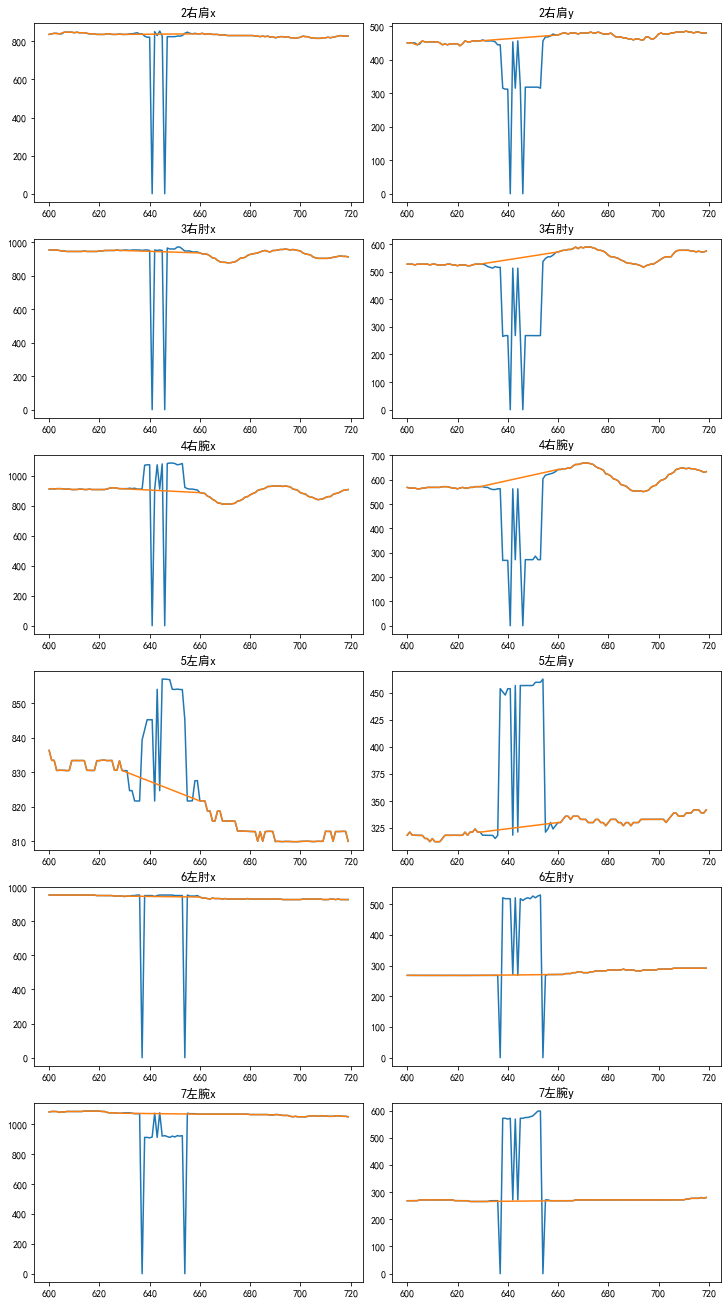

In [62]:
row = 6
col = 12 // row
fig,axes = plt.subplots(row, col, figsize=(10,18), layout='constrained')
for j in range(2,8):
    i = j - 2
    axes[2*i//col, 2*i%col].title.set_text(df_column_changed.columns[3*j])
    axes[2*i//col, 2*i%col].plot(df.index[600:720],df.iloc[600:720,3*j])
    axes[2*i//col, 2*i%col].plot(df.index[600:720],df_fill_error.iloc[600:720,3*j])
    axes[2*i//col, 2*i%col+1].title.set_text(df_column_changed.columns[3*j+1])
    axes[2*i//col, 2*i%col+1].plot(df.index[600:720],df.iloc[600:720,3*j+1])
    axes[2*i//col, 2*i%col+1].plot(df.index[600:720],df_fill_error.iloc[600:720,3*j+1])
plt.savefig('双臂异常帧线性插值图.svg', dpi=200)
plt.show()

In [63]:
# 自定义的滑动平均函数, arr是np.array类型, window_size为奇数
def move_average(arr, window_size):
    new_arr = np.convolve(arr, np.ones((window_size,))/window_size, mode='same')
    for i in range(window_size//2):
        new_arr[i] = arr[:2*i+1].sum()/(2*i+1)
        new_arr[len(arr)-1-i] = arr[-2*i-1:].sum()/(2*i+1)
    return new_arr

In [64]:
df_move_average = df_fill_error.copy()
df_move_average = df_move_average.apply(lambda x:move_average(x,15), axis=0)
df_move_average.to_excel('keypoints(processed).xlsx')
df_move_average

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,736.243000,559.675000,0.650311,830.475000,515.602000,0.626633,836.309000,600.905000,0.620409,912.859000,...,0.745269,715.530000,539.065000,0.703324,736.274000,583.396000,0.082676,715.718000,486.126000,1.025990
1,735.289000,556.763333,0.607014,828.538667,512.640667,0.633446,835.353000,598.949667,0.622196,912.905667,...,0.743171,715.523667,535.203667,0.691652,736.274000,581.374667,0.086199,715.702667,483.253000,1.005325
2,735.110600,553.832200,0.611723,828.740000,509.718400,0.635577,834.620000,596.795400,0.608608,913.499800,...,0.764705,714.988200,532.628600,0.701352,734.516200,579.771200,0.091796,715.698200,481.458600,1.002985
3,735.434571,552.543286,0.636086,827.562429,507.584714,0.633975,834.289286,592.102571,0.602197,914.184143,...,0.761448,715.148000,530.693571,0.717664,734.181857,579.104857,0.083817,715.679714,479.841143,1.003262
4,734.972000,550.213222,0.648676,827.553111,505.100111,0.633372,834.107556,588.507444,0.603854,916.178000,...,0.756769,714.928444,528.642000,0.728304,733.355444,578.068667,0.079145,715.665444,477.639667,1.003326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,697.085000,404.728222,0.440814,807.605778,404.017556,0.676219,812.877444,480.310444,0.642313,890.045444,...,0.760475,682.680111,389.984444,0.529909,703.299667,457.392889,0.276732,692.203556,362.811778,0.805833
920,697.210571,405.427143,0.437540,806.954714,403.276571,0.676322,812.883714,480.310286,0.635842,891.062000,...,0.755481,682.910286,391.105571,0.522153,703.521143,457.592571,0.269673,692.193714,362.925000,0.810678
921,696.859400,402.571800,0.431666,806.951200,403.099200,0.675592,812.881600,480.311600,0.630882,892.306200,...,0.740047,682.154000,388.421200,0.514864,703.945000,457.914200,0.273283,692.195000,363.098800,0.805334
922,697.054000,406.703667,0.422011,806.940000,402.723333,0.668966,812.889333,480.310000,0.627553,893.283333,...,0.735929,682.337000,392.943000,0.501651,705.890000,458.666333,0.255979,692.173333,363.506333,0.836592


In [ ]:
row = 14
col = 28 // row
fig,axes = plt.subplots(row, col, figsize=(10,36), layout='constrained')
for i in range(14):
    axes[2*i//col, 2*i%col].title.set_text(df_column_changed.columns[3*i])
    axes[2*i//col, 2*i%col].plot(df.index/24,df[3*i])
    axes[2*i//col, 2*i%col].plot(df.index/24,df_move_average[3*i])
    axes[2*i//col, 2*i%col+1].title.set_text(df_column_changed.columns[3*i+1])
    axes[2*i//col, 2*i%col+1].plot(df.index/24,df[3*i+1])
    axes[2*i//col, 2*i%col+1].plot(df.index/24,df_move_average[3*i+1])
#plt.savefig('move_average.svg', dpi=200)
plt.show()

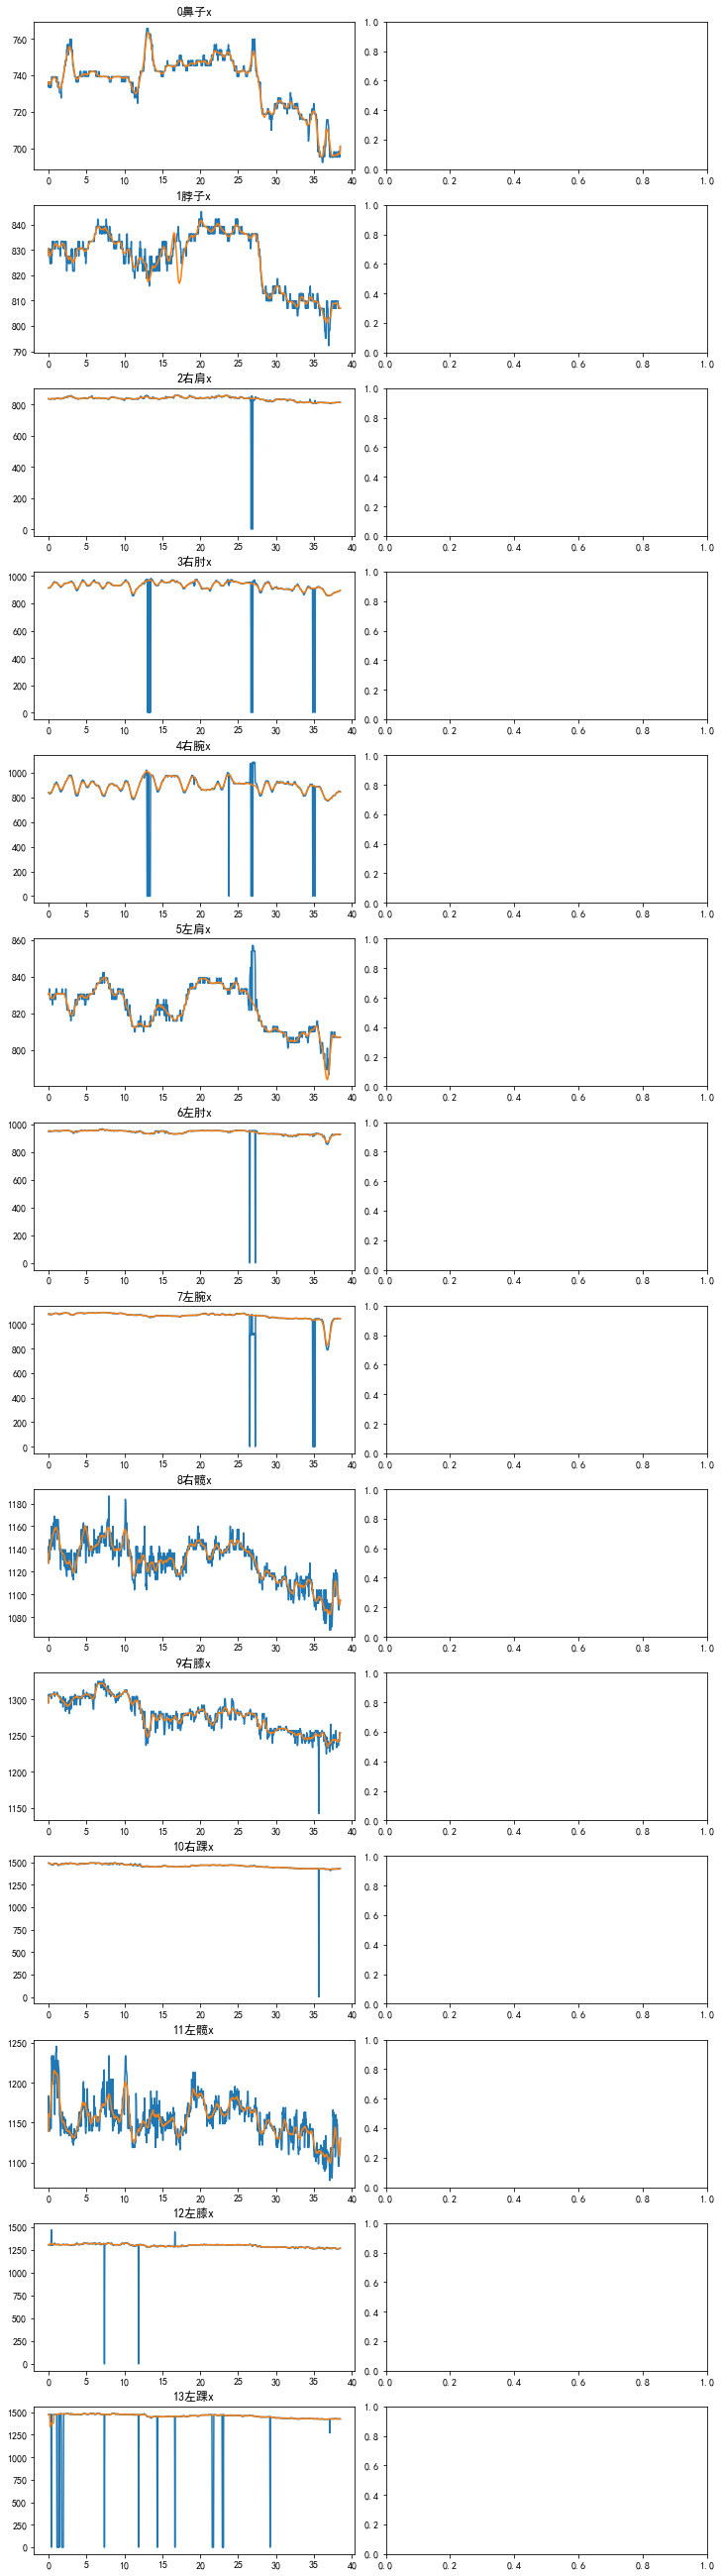

In [73]:
row = 14
col = 28 // row
fig,axes = plt.subplots(row, col, figsize=(10,36), layout='constrained')
for i in range(14):
    axes[2*i//col, 2*i%col].title.set_text(df_column_changed.columns[3*i])
    axes[2*i//col, 2*i%col].plot(df.index/24,df[3*i])
    axes[2*i//col, 2*i%col].plot(df.index/24,df_move_average[3*i])
    axes[2*i//col, 2*i%col+1].title.set_text(df_column_changed.columns[3*i+1])
    axes[2*i//col, 2*i%col+1].plot(df.index/24,df[3*i+1])
    axes[2*i//col, 2*i%col+1].plot(df.index/24,df_move_average[3*i+1])
#plt.savefig('move_average.svg', dpi=200)
plt.show()

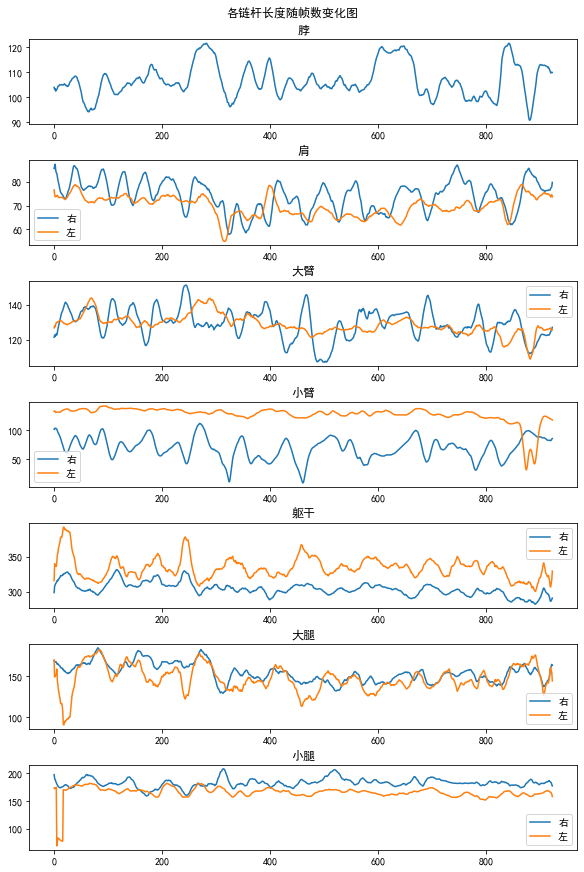

In [66]:
joints_pair = [[[1,2],[1,5]],
                [[2,3],[5,6]],
                [[3,4],[6,7]],
                [[1,8],[1,11]],
                [[8,9],[11,12]],
                [[9,10],[12,13]]]
bone_title = ['肩','大臂','小臂','躯干','大腿','小腿']

fig, axes = plt.subplots(7,1, figsize=(8,12), layout='constrained')
axes[0].set_title('脖')
axes[0].plot(cal_joints_lenths_2d(df_move_average, [0,1]))
for i in range(6):
    axes[i+1].set_title(bone_title[i])
    axes[i+1].plot(cal_joints_lenths_2d(df_move_average, joints_pair[i][0]), label='右')
    axes[i+1].plot(cal_joints_lenths_2d(df_move_average, joints_pair[i][1]), label='左')
    axes[i+1].legend()

plt.suptitle('各链杆长度随帧数变化图')

plt.savefig('各链杆长度随帧数变化图.svg', dpi=200)

plt.show()

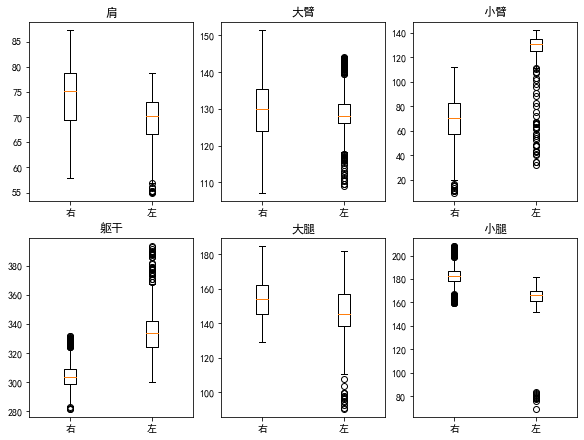

In [67]:
joints_pair = [[[1,2],[1,5]],
                [[2,3],[5,6]],
                [[3,4],[6,7]],
                [[1,8],[1,11]],
                [[8,9],[11,12]],
                [[9,10],[12,13]]]
bone_title = ['肩','大臂','小臂','躯干','大腿','小腿']
fig, axes = plt.subplots(2,3, figsize=(8,6), layout='constrained')
for i in range(6):
    axes[i//3, i%3].set_title(bone_title[i])
    axes[i//3, i%3].boxplot([cal_joints_lenths_2d(df_move_average, joints_pair[i][0]),cal_joints_lenths_2d(df_move_average, joints_pair[i][1])], labels=['右','左'])

plt.savefig('各链杆长度箱型图.svg', dpi=200)
plt.show()

In [68]:
len_ls = []
len_ls.append(cal_joints_lenths_2d(df_move_average, [0,1]).mean())
for i in range(6):
    len_ls.append(cal_joints_lenths_2d(df_move_average, joints_pair[i][0]).mean())
    len_ls.append(cal_joints_lenths_2d(df_move_average, joints_pair[i][1]).mean())
    # len_ls.append(np.percentile(cal_joints_lenths_2d(df_move_average, joints_pair[i][0]),75))
    # len_ls.append(np.percentile(cal_joints_lenths_2d(df_move_average, joints_pair[i][1]),75))
chain_rod_columns = ['颈部','右半肩','左半肩','右大臂','左大臂','右小臂','左小臂','右躯干','左躯干','右大腿','左大腿','右小腿','左小腿']
chain_rod_length = pd.Series(len_ls, index=chain_rod_columns)

chain_rod_length['右小臂'] = chain_rod_length['左小臂']

chain_rod_length

颈部     106.851441
右半肩     73.987678
左半肩     69.749962
右大臂    129.417906
左大臂    128.851136
右小臂    127.240588
左小臂    127.240588
右躯干    303.976661
左躯干    334.353900
右大腿    154.261144
左大腿    147.059862
右小腿    182.643847
左小腿    165.526016
dtype: float64

In [69]:
chain_rod_length.to_excel('各链杆相对长度.xlsx', header=False)